# Библиотека

In [ ]:
import h5py
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pandas as pd
import torch
from google.colab import drive

In [ ]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
# Стили для красивых графиков
plt.style.use('seaborn-v0_8')
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300
})

# Загрузка данных

In [ ]:
# подключаем диск, на котором хранится датасет
drive.mount('/content/drive')

Mounted at /content/drive


Датасет решений уравнения Гросса-Питаевского с гармоническим потеницалом сгенерирован с помощью пакета matlab split-step методом в виде файлов .mat с сжатием HDF5 по 100 семплов.

Семпл представляет из себя волновую функцию на плоской сетке 256*256 с 51 временными шагами (эволюция моделировалась на 1000 шагах)

In [ ]:
# Настройки
data_path = '/content/drive/MyDrive/Dataset_GPE_dynamical_mat/nls_dataset_part_1.mat'  # Путь к файлу
output_dir = '/content/drive/MyDrive/Dataset_GPE_dynamical_mat/eda_plots'
batch_size = 20  #разбиваем на батчи
Path(output_dir).mkdir(exist_ok=True)

Проверяем размерность данных

In [ ]:
with h5py.File(data_path, 'r') as f:
    print("Ключи:", list(f.keys()))
    print("partial_reals shape:", f['partial_reals'].shape)
    print("partial_imags shape:", f['partial_imags'].shape)
    print("partial_params shape:", f['partial_params'].shape)
    print("x shape:", f['x'].shape)
    print("y shape:", f['y'].shape)

Ключи: ['partial_imags', 'partial_params', 'partial_reals', 'x', 'y']
partial_reals shape: (256, 256, 51, 100)
partial_imags shape: (256, 256, 51, 100)
partial_params shape: (3, 100)
x shape: (256, 1)
y shape: (256, 1)


Загружаем данные

In [ ]:
# Загрузка данных
def load_data_in_batches(data_path, batch_size):
    with h5py.File(data_path, 'r') as f:
        psi_reals = f['partial_reals']  # (256, 256, 51, 100)
        psi_imags = f['partial_imags']
        params = f['partial_params']  # (3, 100)
        x = f['x'][:].flatten()  # (256,)
        y = f['y'][:].flatten()

        n_samples = psi_reals.shape[3]
        for start_idx in range(0, n_samples, batch_size):
            end_idx = min(start_idx + batch_size, n_samples)
            # Транспонируем: (256, 256, 51, batch) -> (batch, 51, 256, 256)
            reals = np.transpose(psi_reals[:, :, :, start_idx:end_idx], (3, 2, 0, 1))
            imags = np.transpose(psi_imags[:, :, :, start_idx:end_idx], (3, 2, 0, 1))
            # Обрезаем до 50 временных точек
            reals = reals[:, :50, :, :]
            imags = imags[:, :50, :, :]
            yield (reals, imags, params[:, start_idx:end_idx].T, x, y)  # params.T: (batch, 3)


In [ ]:
# Тест загрузки первого батча
for batch in load_data_in_batches(data_path, batch_size):
    psi_reals, psi_imags, params, x, y = batch
    print("psi_reals shape:", psi_reals.shape)  # (batch, 50, 256, 256)
    print("params shape:", params.shape)  # (batch, 3)
    break

psi_reals shape: (20, 50, 256, 256)
params shape: (20, 3)


# Анализ данных

In [ ]:
norms = []
param_stats = {'gamma': [], 'omega_x': [], 'omega_y': []}
psi_stats = {'mean': [], 'std': [], 'min': [], 'max': []}
residuals = []
dirichlet_boundary = []
neumann_boundary = []

dx = 10.0 / 255  # Для N-1 интервалов
dt = 9.8 / 50

for batch_idx, (psi_reals, psi_imags, params, x, y) in enumerate(load_data_in_batches(data_path, batch_size)):
    print(f"Обработка батча {batch_idx+1}/{int(100/batch_size)+1}")

    # Параметры
    param_stats['gamma'].extend(params[:, 0])
    param_stats['omega_x'].extend(params[:, 1])
    param_stats['omega_y'].extend(params[:, 2])

    # Простые статистики в numpy (считаем по батчам)
    psi_abs = np.sqrt(psi_reals**2 + psi_imags**2)  # (batch, 50, 256, 256)
    psi_stats['mean'].extend(np.mean(psi_abs, axis=(1, 2, 3)))
    psi_stats['std'].extend(np.std(psi_abs, axis=(1, 2, 3)))
    psi_stats['min'].extend(np.min(psi_abs, axis=(1, 2, 3)))
    psi_stats['max'].extend(np.max(psi_abs, axis=(1, 2, 3)))

    # Нормы
    norm = np.sum(psi_abs**2, axis=(2, 3)) * dx**2  # (batch, 50)
    norms.extend(norm)

    # Очистка
    del psi_abs, norm
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Тяжёлые вычисления по одному сэмплу
    for s in range(psi_reals.shape[0]):
        # Подвыборка сетки (для памяти)
        x_sub = x[::]  # (256,)
        y_sub = y[::]  # (256,)
        psi_re_s = torch.tensor(psi_reals[s:s+1, :, ::, ::], dtype=torch.float32)
        psi_im_s = torch.tensor(psi_imags[s:s+1, :, ::, ::], dtype=torch.float32)
        psi_s = psi_re_s + 1j * psi_im_s

        # Центральные разности для ∂/∂t (2-й порядок)
        dpsi_dt_s = (psi_s[:, 2:, :, :] - psi_s[:, :-2, :, :]) / (2 * dt)  # (1, 48, 256, 256)

        # Центральные разности для ∂/∂x, ∂²/∂x²
        dpsi_dx_s = (psi_s[:, :, 2:, :] - psi_s[:, :, :-2, :]) / (2 * dx)  # (1, 50, 254, 256)
        dpsi_dxx_s = (psi_s[:, :, 2:, :] - 2 * psi_s[:, :, 1:-1, :] + psi_s[:, :, :-2, :]) / (dx**2)  # (1, 50, 254, 256)

        # Центральные разности для ∂/∂y, ∂²/∂y²
        dpsi_dy_s = (psi_s[:, :, :, 2:] - psi_s[:, :, :, :-2]) / (2 * dx)  # (1, 50, 256, 254)
        dpsi_dyy_s = (psi_s[:, :, :, 2:] - 2 * psi_s[:, :, :, 1:-1] + psi_s[:, :, :, :-2]) / (dx**2)  # (1, 50, 256, 254)

        # Лапласиан
        laplacian_s = dpsi_dxx_s[:, :-2, :, :-2] + dpsi_dyy_s[:, :-2, :-2, :]  # (1, 48, 254, 254)

        # Невязка
        t_slice = slice(0, -2)  # 48
        x_slice = slice(0, -2)  # 254
        y_slice = slice(0, -2)  # 254
        V_s = 0.5 * (torch.tensor(params[s:s+1, 1]**2, dtype=torch.float32).view(-1, 1, 1, 1) *
                     (torch.tensor(x_sub, dtype=torch.float32).view(1, 1, -1, 1).expand(1, 50, len(x_sub), len(y_sub)))**2 +
                     torch.tensor(params[s:s+1, 2]**2, dtype=torch.float32).view(-1, 1, 1, 1) *
                     (torch.tensor(y_sub, dtype=torch.float32).view(1, 1, 1, -1).expand(1, 50, len(x_sub), len(y_sub)))**2)
        gamma_s = torch.tensor(params[s:s+1, 0], dtype=torch.float32).view(-1, 1, 1, 1)
        residual_s = (1j * dpsi_dt_s[:, :, x_slice, y_slice] +
                      0.5 * laplacian_s -
                      V_s[:, t_slice, x_slice, y_slice] * psi_s[:, t_slice, x_slice, y_slice] -
                      gamma_s * torch.abs(psi_s[:, t_slice, x_slice, y_slice])**2 * psi_s[:, t_slice, x_slice, y_slice])
        residuals.append(torch.mean(torch.abs(residual_s)**2, dim=(1, 2, 3)).numpy()[0])

        # Дирихле
        boundary_psi_s = (torch.abs(psi_s[:, :, [0, -1], :]).mean(dim=(1, 2, 3)) +
                          torch.abs(psi_s[:, :, :, [0, -1]]).mean(dim=(1, 2, 3)))
        dirichlet_boundary.append(boundary_psi_s.numpy()[0])

        # Нейман
        dpsi_re_dx_s = (psi_re_s[:, :, 2:, :] - psi_re_s[:, :, :-2, :]) / (2 * dx)  # (1, 50, 254, 256)
        dpsi_im_dx_s = (psi_im_s[:, :, 2:, :] - psi_im_s[:, :, :-2, :]) / (2 * dx)
        dpsi_dx_s = dpsi_re_dx_s + 1j * dpsi_im_dx_s
        dpsi_re_dy_s = (psi_re_s[:, :, :, 2:] - psi_re_s[:, :, :, :-2]) / (2 * dx)  # (1, 50, 256, 254)
        dpsi_im_dy_s = (psi_im_s[:, :, :, 2:] - psi_im_s[:, :, :, :-2]) / (2 * dx)
        dpsi_dy_s = dpsi_re_dy_s + 1j * dpsi_im_dy_s
        psi_conj_s = torch.conj(psi_s)
        j_x_s = (1j/2) * (psi_s[:, :, 1:-1, :] * torch.conj(dpsi_dx_s) - psi_conj_s[:, :, 1:-1, :] * dpsi_dx_s)
        j_y_s = (1j/2) * (psi_s[:, :, :, 1:-1] * torch.conj(dpsi_dy_s) - psi_conj_s[:, :, :, 1:-1] * dpsi_dy_s)
        j_n_x_s = torch.abs(j_x_s[:, :, [0, -1], :]).mean(dim=(1, 2, 3))
        j_n_y_s = torch.abs(j_y_s[:, :, :, [0, -1]]).mean(dim=(1, 2, 3))
        neumann_boundary.append((j_n_x_s + j_n_y_s).numpy()[0])

        # Очистка памяти
        del psi_re_s, psi_im_s, psi_s, dpsi_dt_s, dpsi_dx_s, dpsi_dxx_s, dpsi_dy_s, dpsi_dyy_s
        del laplacian_s, residual_s, boundary_psi_s, j_x_s, j_y_s, j_n_x_s, j_n_y_s
        #del dpsi_re_dx_s, dpsi_im_dx_s, dpsi_dx_s, dpsi_re_dy_s, dpsi_im_dy_s, dpsi_dy_s, psi_conj_s
        del V_s, gamma_s
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

norms = np.array(norms)  # (100, 50)
residuals = np.array(residuals)  # (100,)
dirichlet_boundary = np.array(dirichlet_boundary)  # (100,)
neumann_boundary = np.array(neumann_boundary)  # (100,)
for key in param_stats:
    param_stats[key] = np.array(param_stats[key])
for key in psi_stats:
    psi_stats[key] = np.array(psi_stats[key])

Обработка батча 1/6
Обработка батча 2/6
Обработка батча 3/6
Обработка батча 4/6
Обработка батча 5/6


#Визуализации

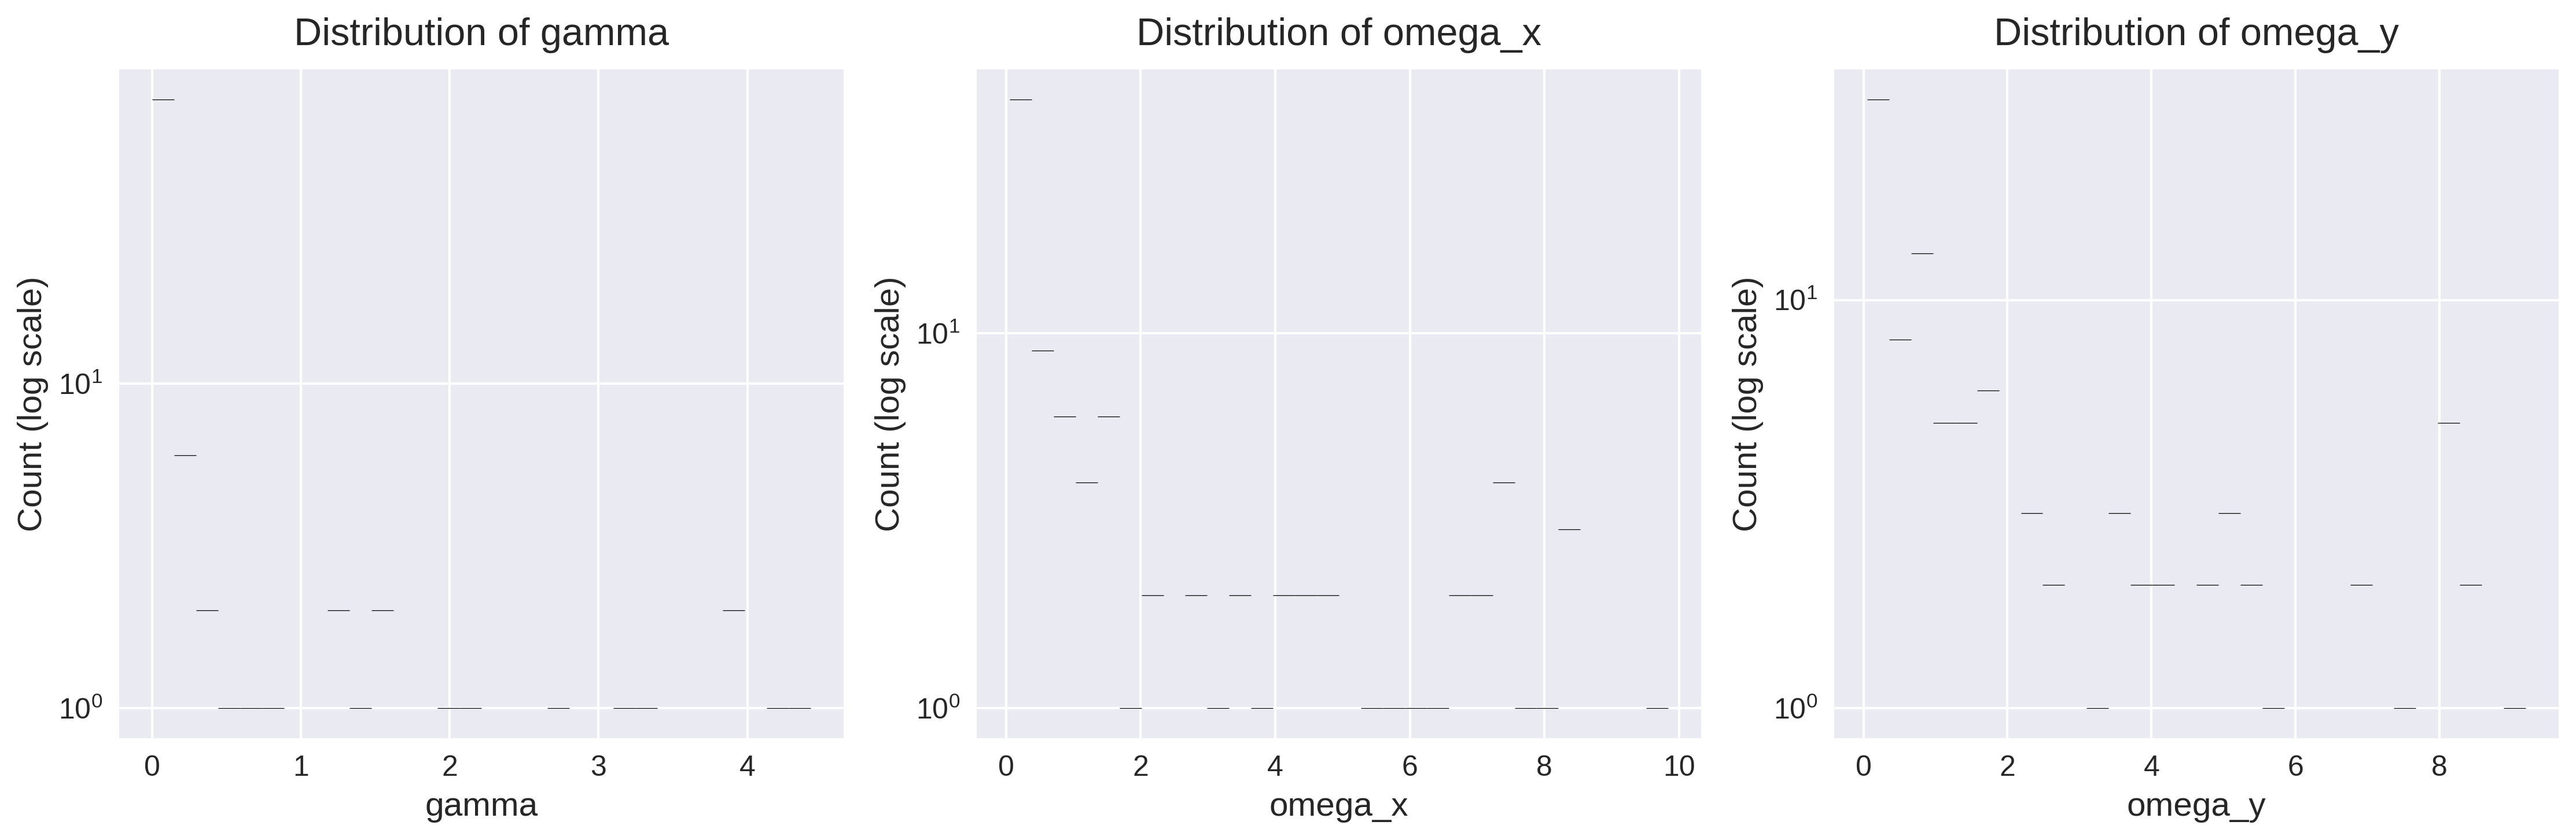

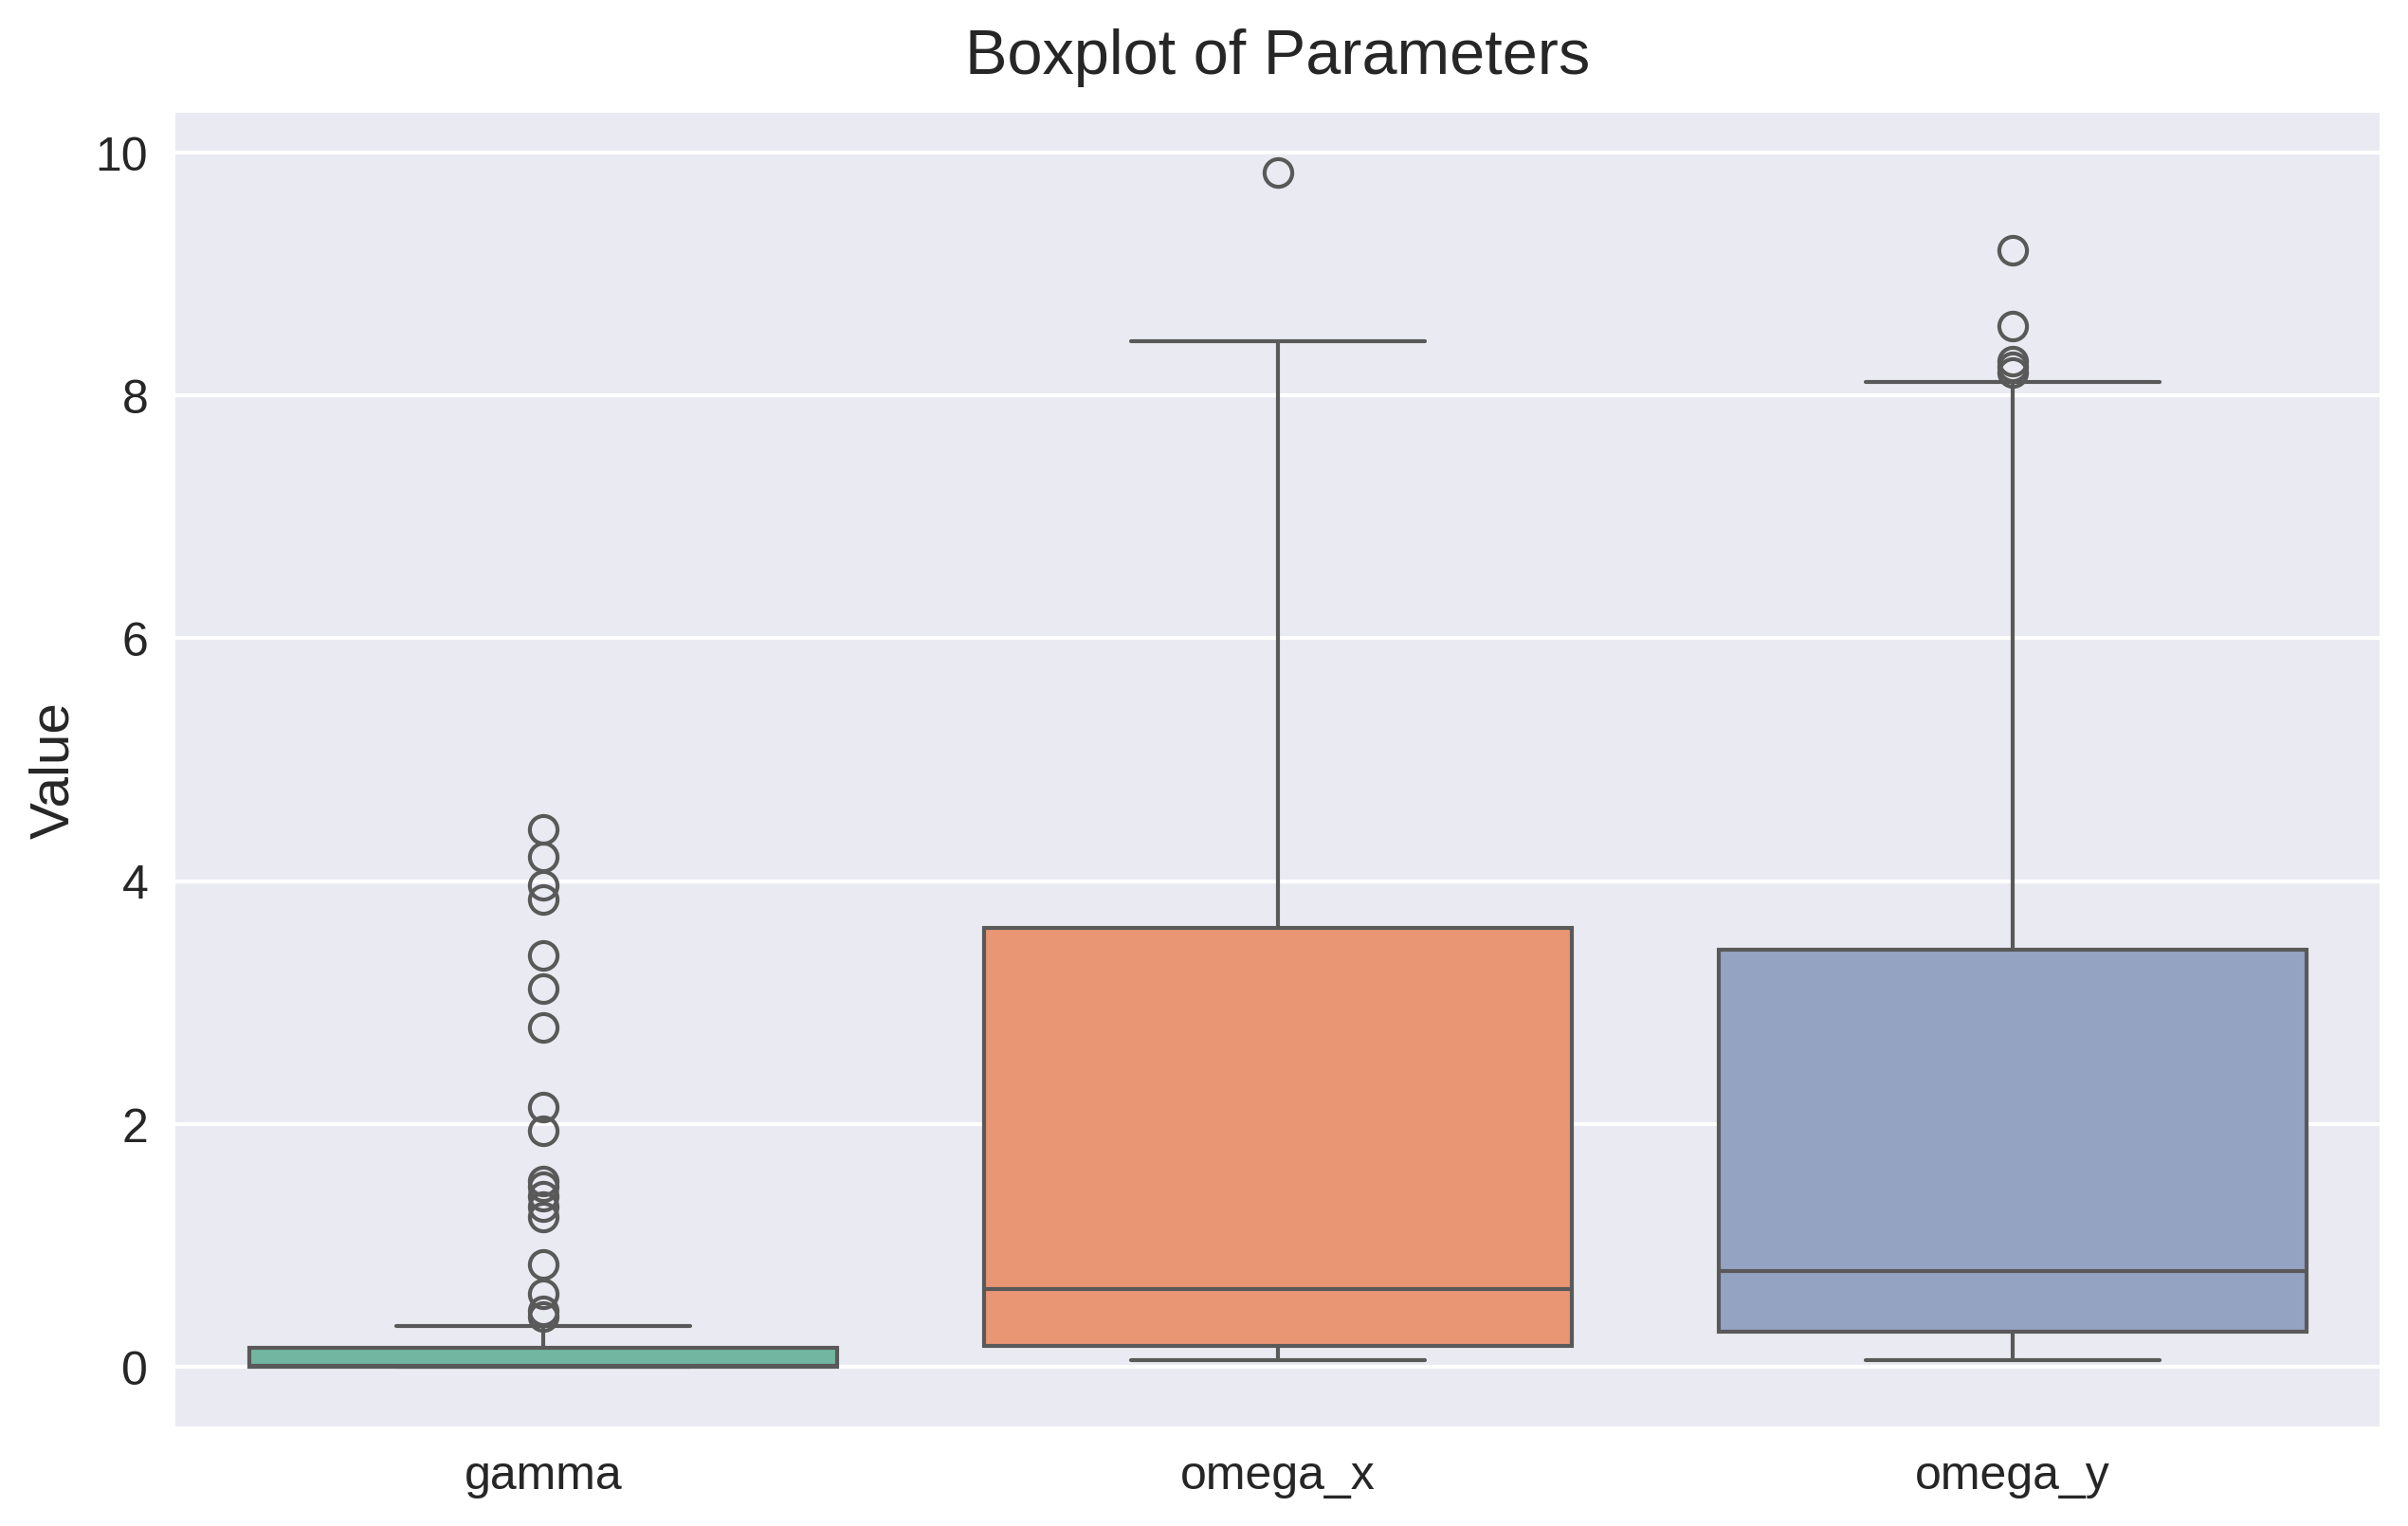

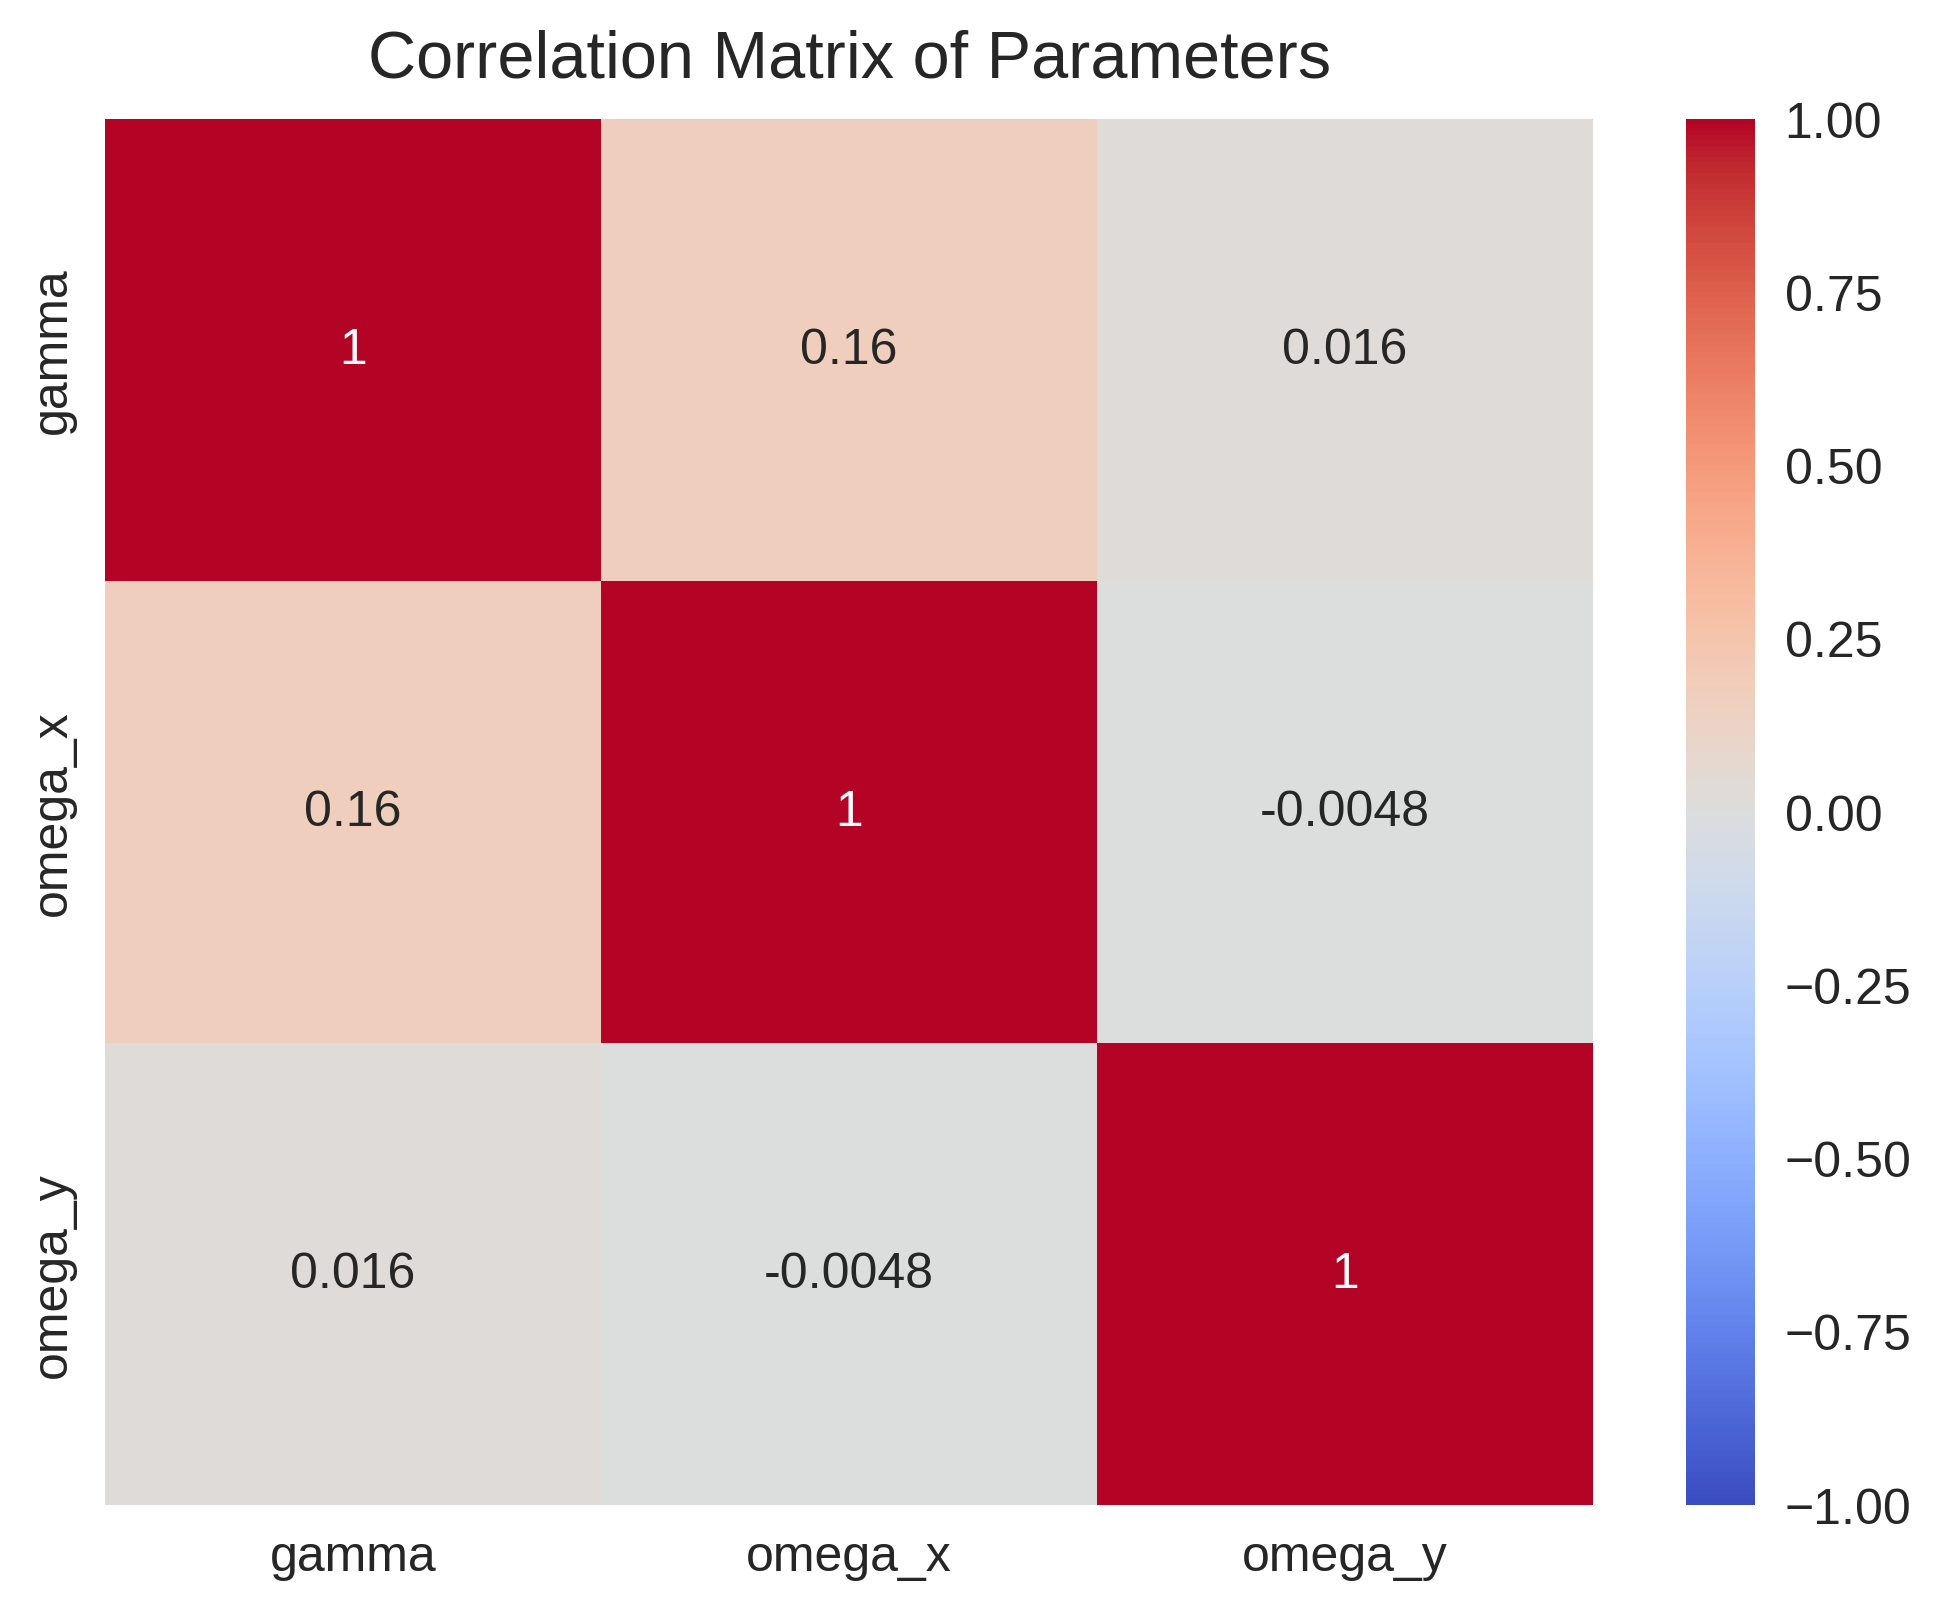

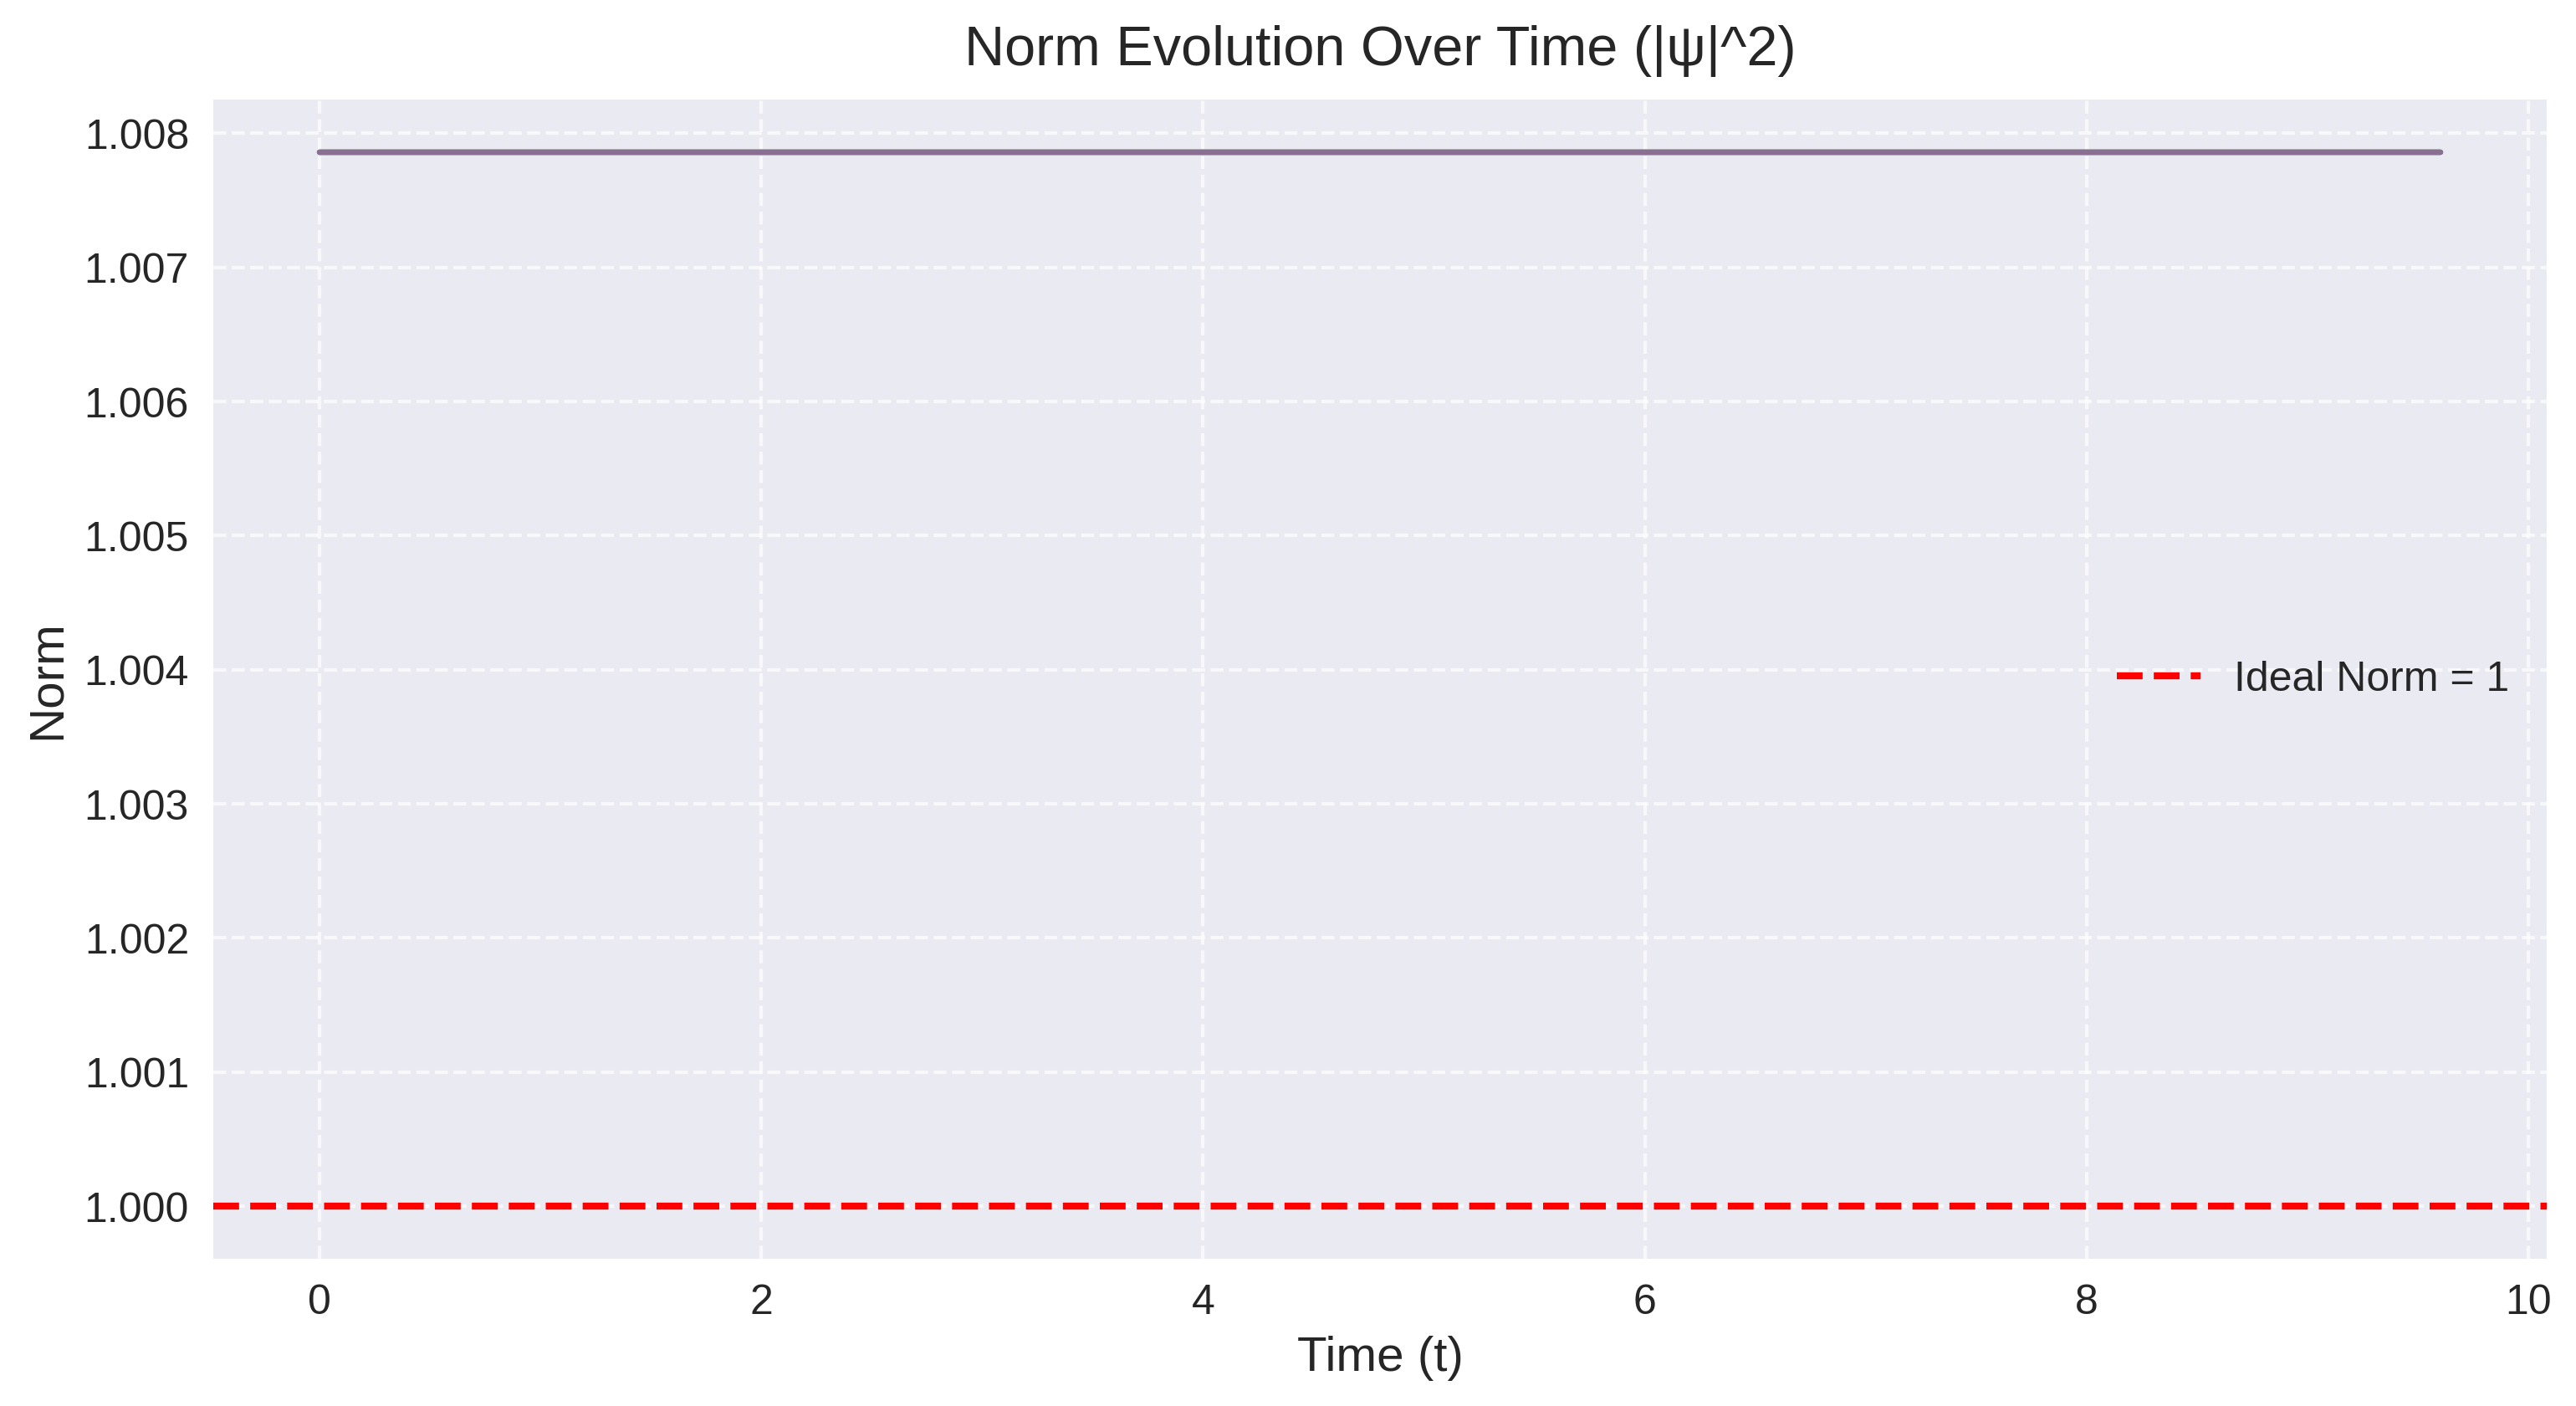

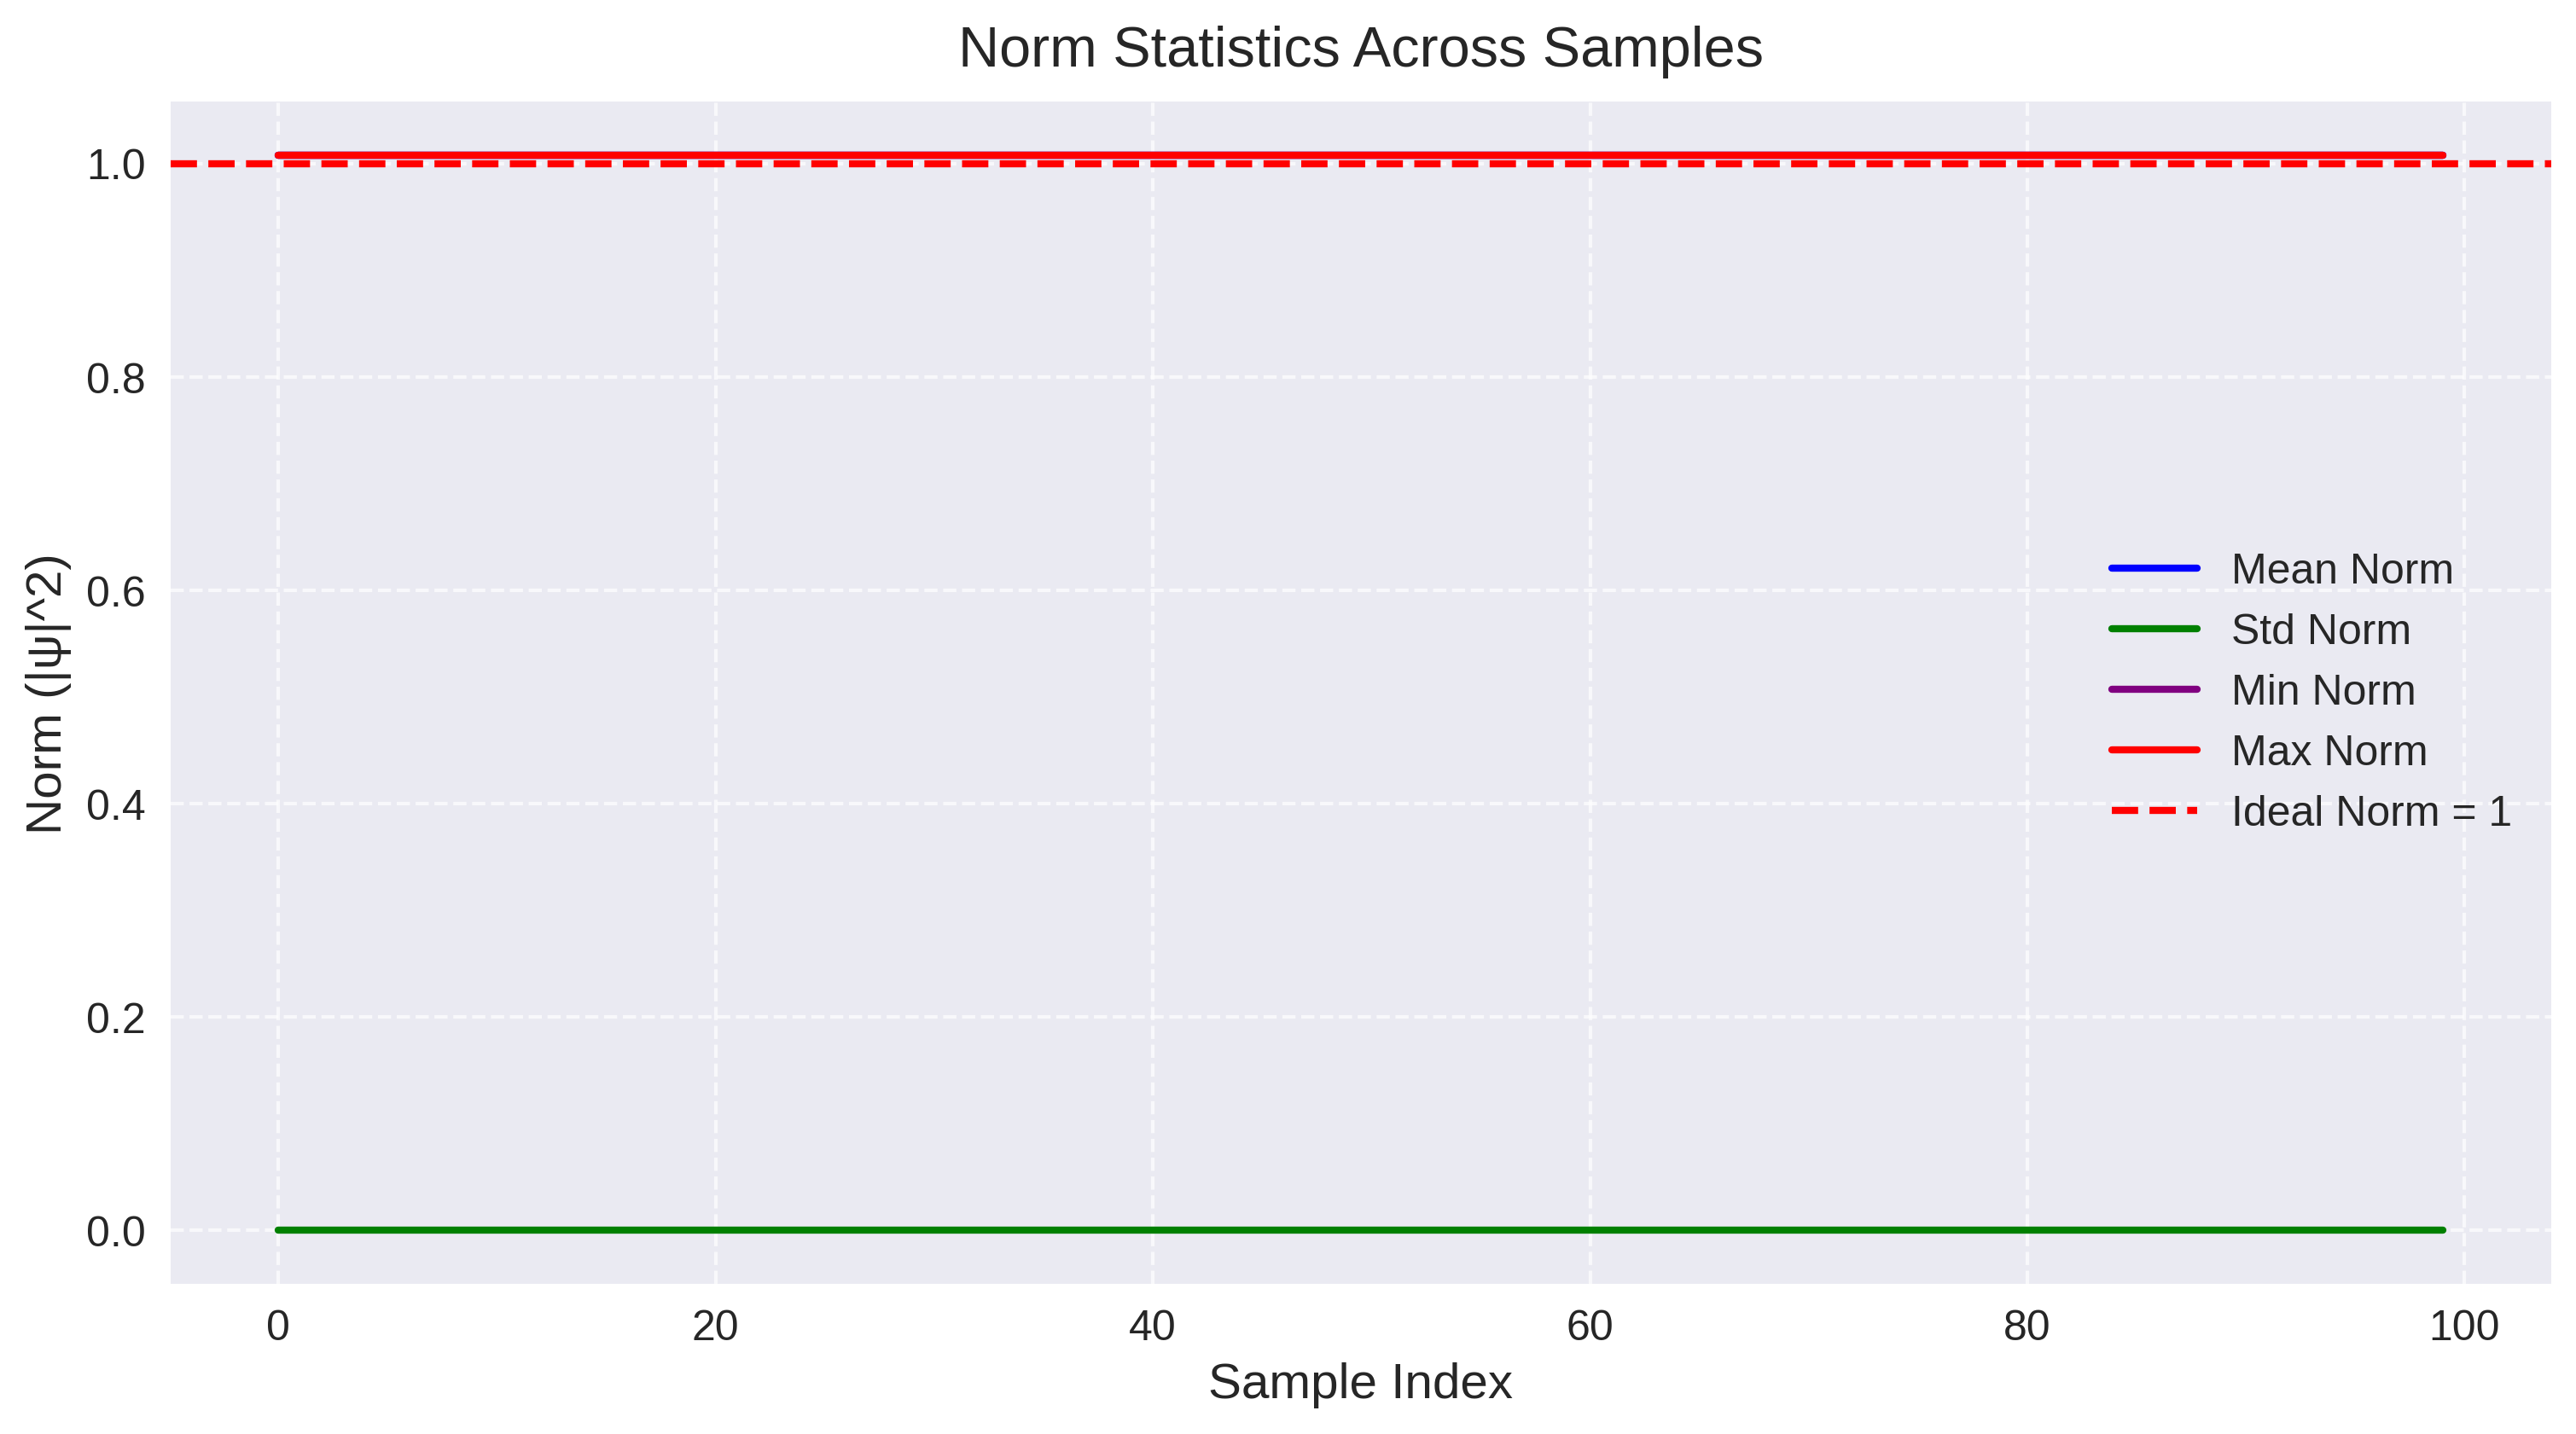

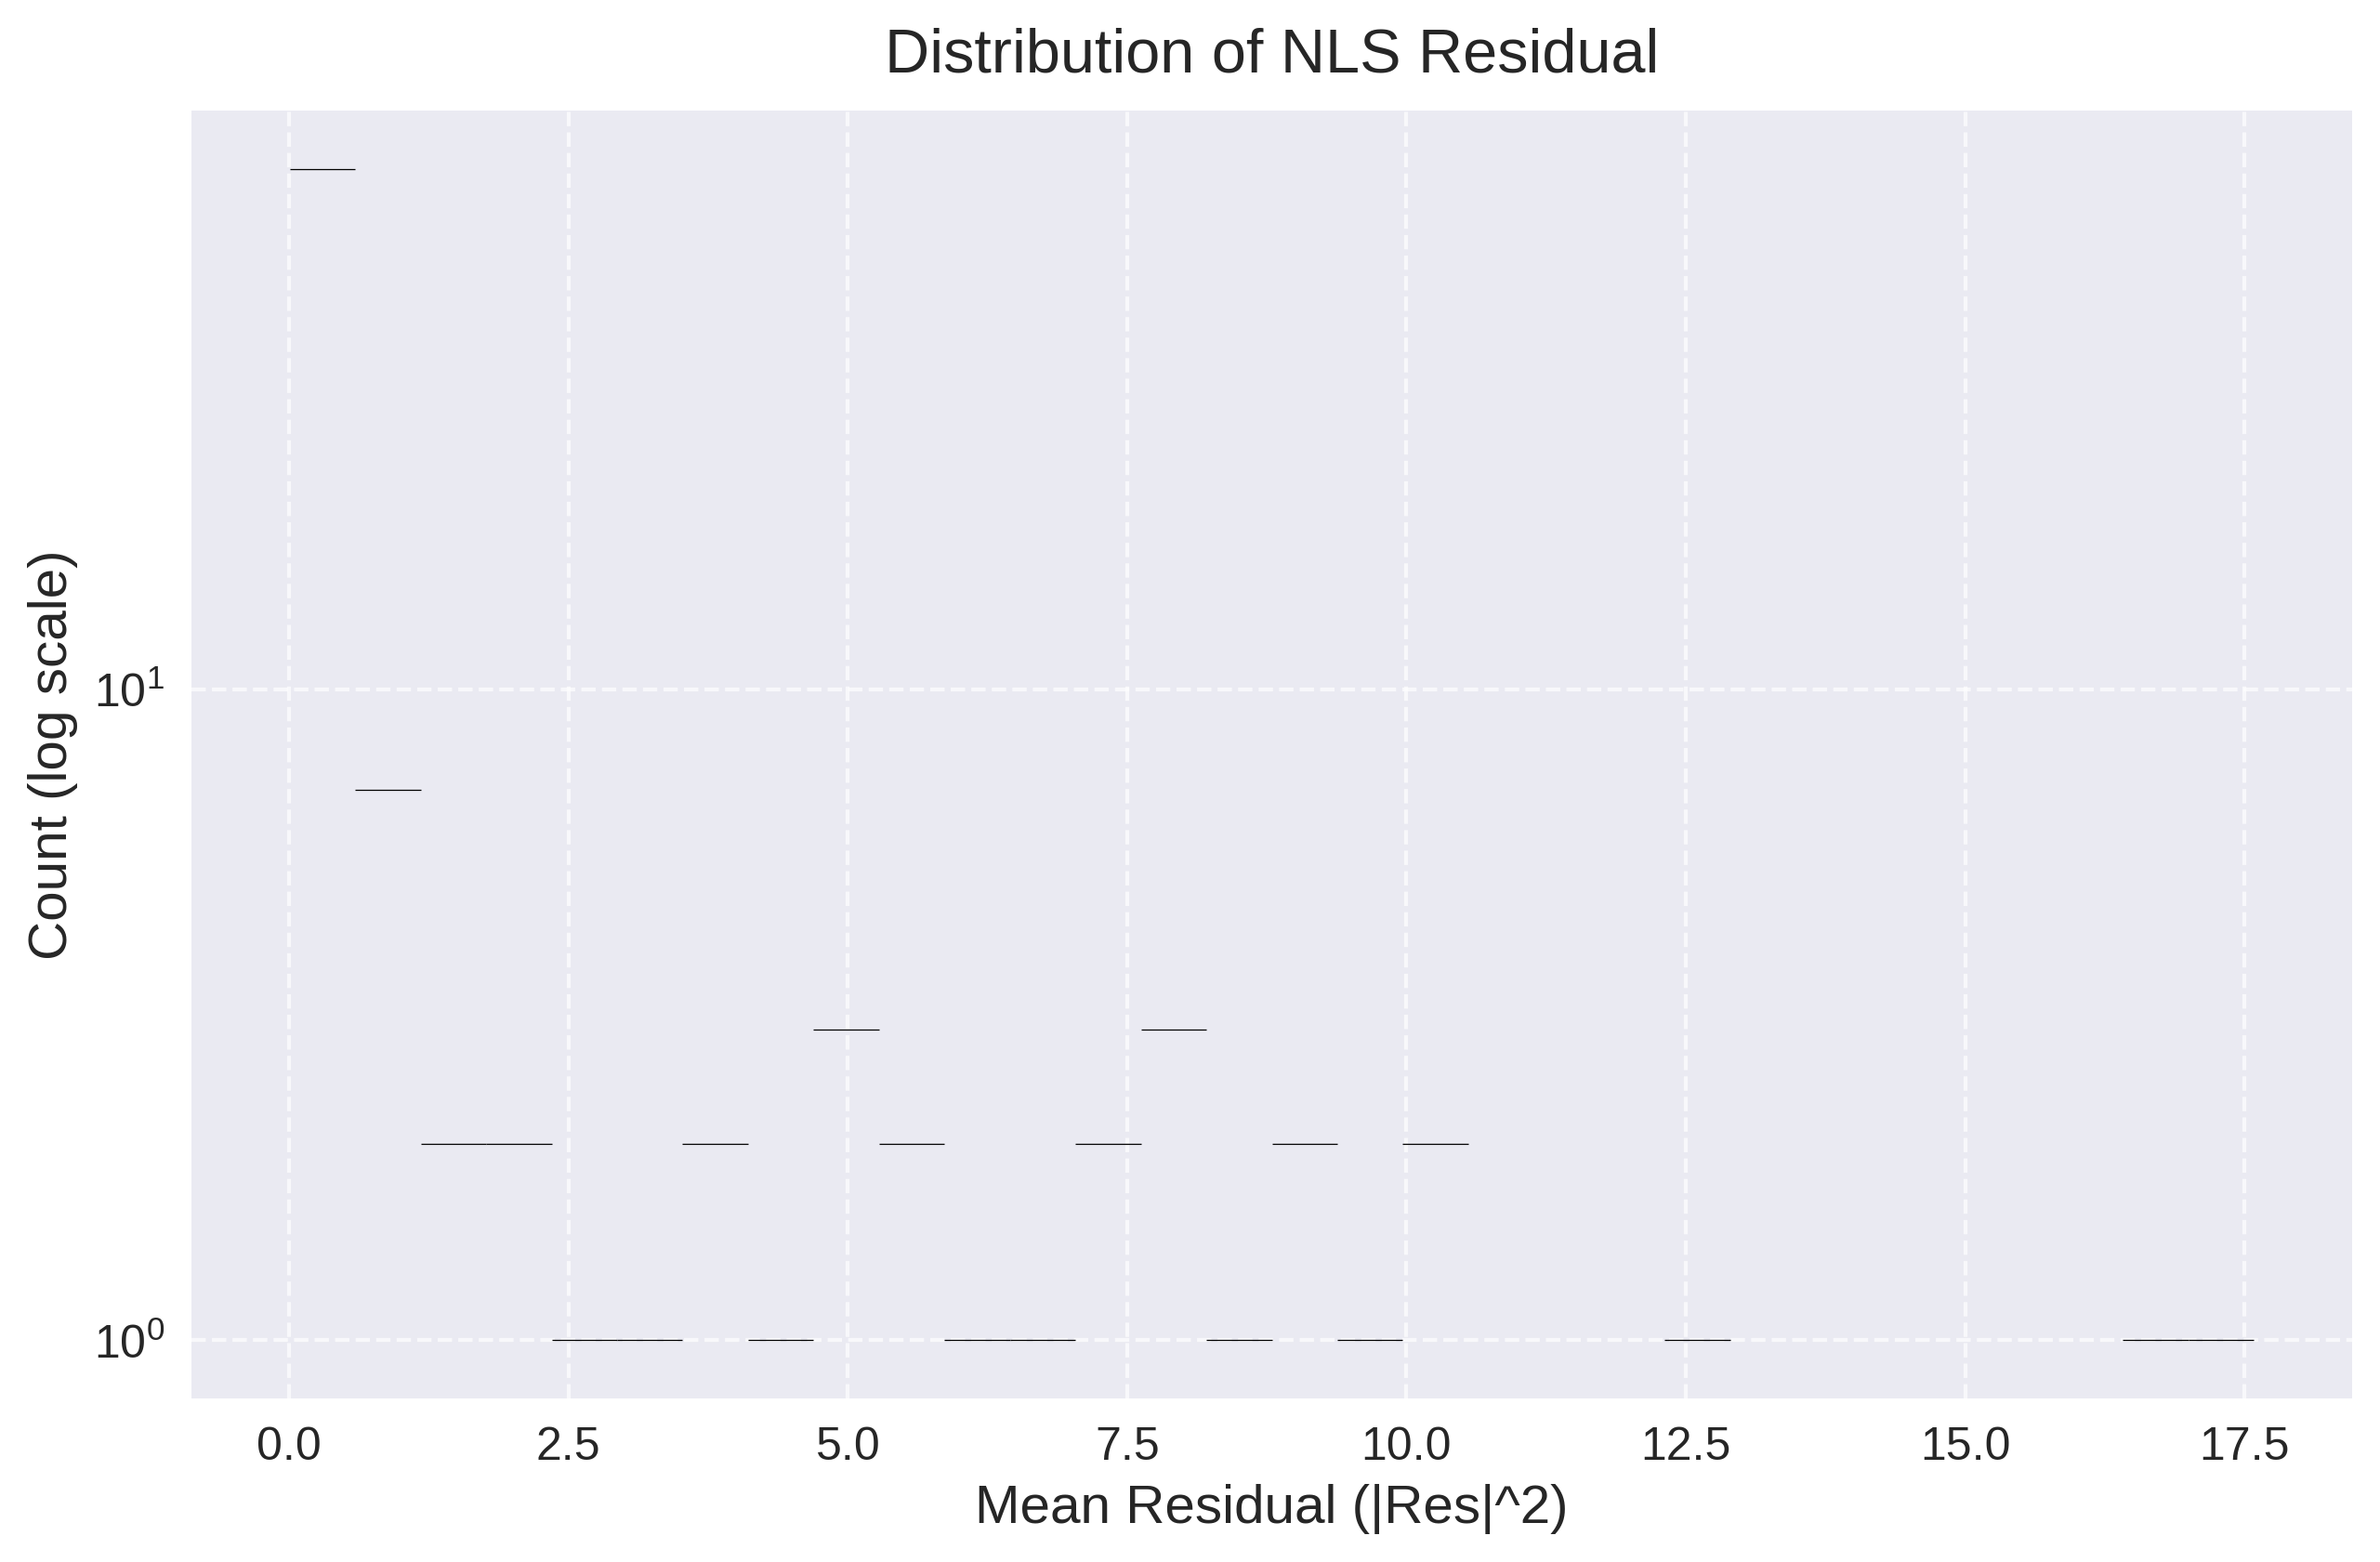

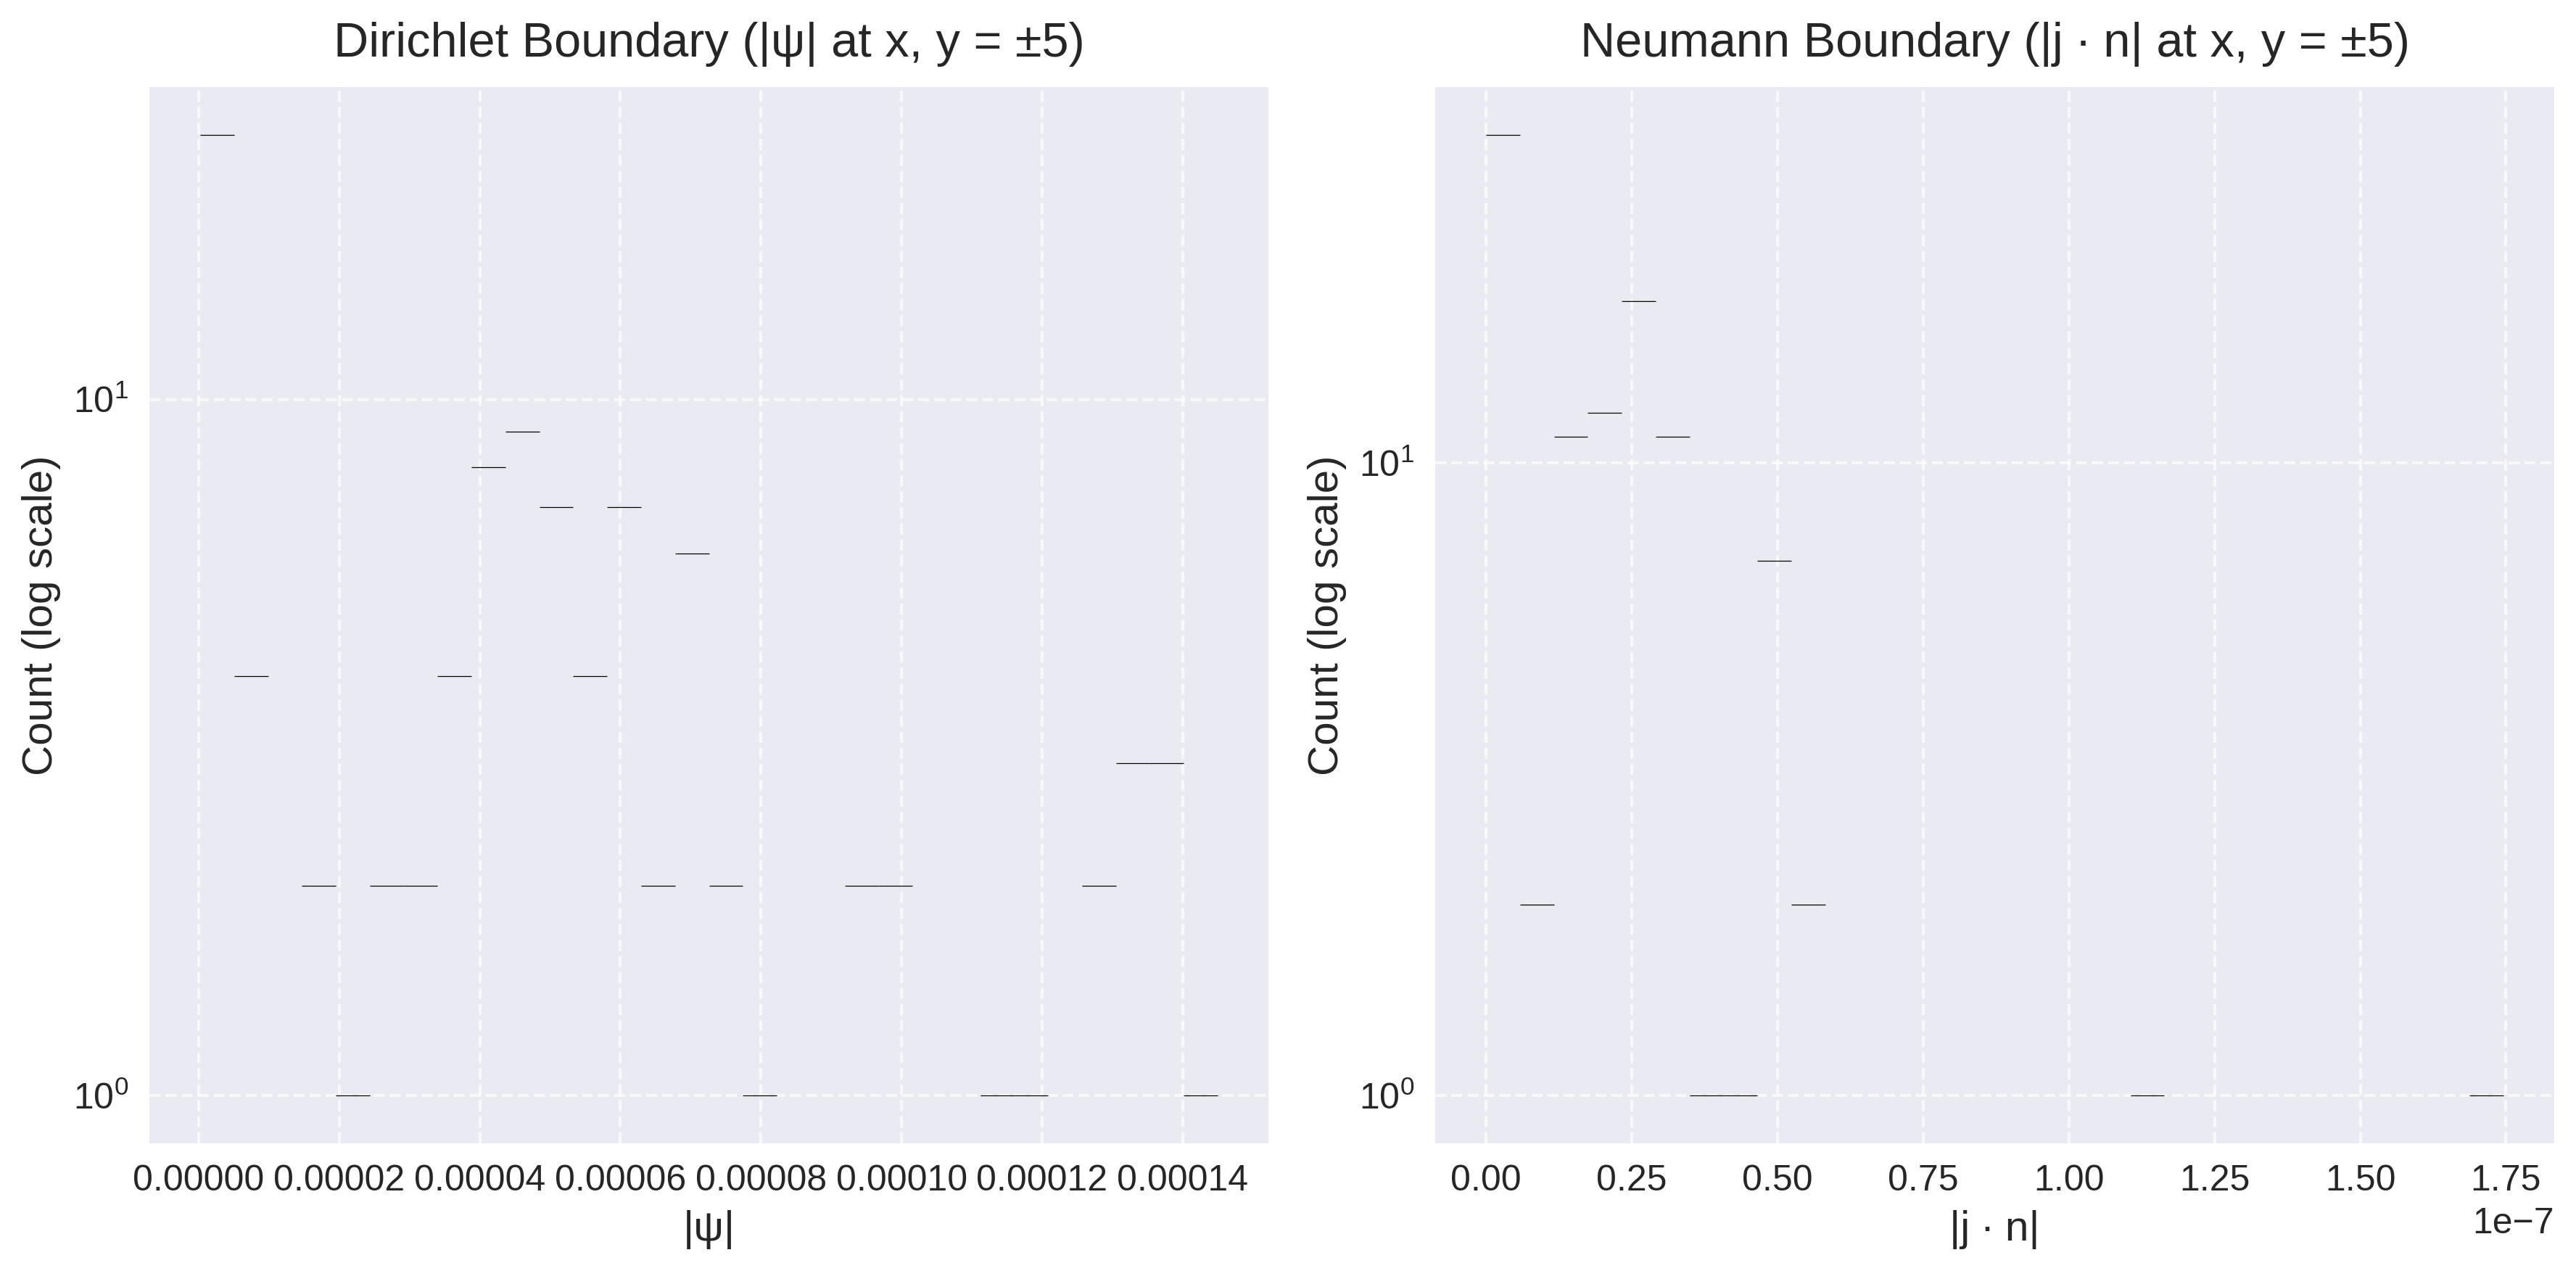

In [ ]:
plt.figure(figsize=(15, 5))
for i, key in enumerate(['gamma', 'omega_x', 'omega_y']):
    plt.subplot(1, 3, i+1)
    sns.histplot(param_stats[key], bins=30, log_scale=(False, True), color='dodgerblue', edgecolor='black')
    plt.title(f'Distribution of {key}', pad=10)
    plt.xlabel(key)
    plt.ylabel('Count (log scale)')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'params_hist.png'))
#plt.close()

plt.figure(figsize=(10, 6))
df_params = pd.DataFrame(param_stats)
sns.boxplot(data=df_params, palette='Set2')
plt.title('Boxplot of Parameters', pad=10)
plt.ylabel('Value')
plt.savefig(os.path.join(output_dir, 'params_boxplot.png'))
#plt.close()

plt.figure(figsize=(8, 6))
sns.heatmap(df_params.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Parameters', pad=10)
plt.savefig(os.path.join(output_dir, 'params_corr.png'))
#plt.close()

plt.figure(figsize=(12, 6))
for i in range(min(10, norms.shape[0])):
    plt.plot(np.arange(50) * 9.8/50, norms[i], alpha=0.6, linewidth=1.5)
plt.axhline(1.0, color='red', linestyle='--', label='Ideal Norm = 1', linewidth=2)
plt.title('Norm Evolution Over Time (|ψ|^2)', pad=10)
plt.xlabel('Time (t)')
plt.ylabel('Norm')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(output_dir, 'norms.png'))
#plt.close()

plt.figure(figsize=(12, 6))
norm_mean = np.mean(norms, axis=1)
norm_std = np.std(norms, axis=1)
norm_min = np.min(norms, axis=1)
norm_max = np.max(norms, axis=1)
plt.plot(norm_mean, label='Mean Norm', color='blue', linewidth=2)
plt.plot(norm_std, label='Std Norm', color='green', linewidth=2)
plt.plot(norm_min, label='Min Norm', color='purple', linewidth=2)
plt.plot(norm_max, label='Max Norm', color='red', linewidth=2)
plt.axhline(1.0, color='red', linestyle='--', label='Ideal Norm = 1', linewidth=2)
plt.title('Norm Statistics Across Samples', pad=10)
plt.xlabel('Sample Index')
plt.ylabel('Norm (|ψ|^2)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(output_dir, 'norm_stats.png'))
#plt.close()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, log_scale=(False, True), color='forestgreen')
plt.title('Distribution of NLS Residual', pad=10)
plt.xlabel('Mean Residual (|Res|^2)')
plt.ylabel('Count (log scale)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(output_dir, 'residuals_hist.png'))
#plt.close()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(dirichlet_boundary, bins=30, color='purple', log_scale=(False, True))
plt.title('Dirichlet Boundary (|ψ| at x, y = ±5)', pad=10)
plt.xlabel('|ψ|')
plt.ylabel('Count (log scale)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.histplot(neumann_boundary, bins=30, color='orange', log_scale=(False, True))
plt.title('Neumann Boundary (|j · n| at x, y = ±5)', pad=10)
plt.xlabel('|j · n|')
plt.ylabel('Count (log scale)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'boundary_conditions.png'))
#plt.close()

with h5py.File(data_path, 'r') as f:
    for i in [0, 50, 99]:
        psi_real = f['partial_reals'][:, :, :, i]  # (256, 256, 51)
        psi_imag = f['partial_imags'][:, :, :, i]
        psi_real = np.transpose(psi_real, (2, 0, 1))[:50, :, :]  # (50, 256, 256)
        psi_imag = np.transpose(psi_imag, (2, 0, 1))[:50, :, :]
        psi_abs2 = psi_real**2 + psi_imag**2
        for t in [0, 25, 49]:
            plt.figure(figsize=(7, 6))
            sns.heatmap(psi_abs2[t], cmap='viridis', cbar_kws={'label': '|ψ|^2'})
            plt.title(f'|ψ|^2 for Sample {i+1}, t={t*9.8/50:.2f}', pad=10)
            plt.xlabel('x')
            plt.ylabel('y')
            plt.savefig(os.path.join(output_dir, f'psi_abs2_sample_{i+1}_t_{t}.png'))
            plt.close()

plt.figure(figsize=(12, 6))
plt.plot(psi_stats['mean'], label='Mean |ψ|', color='blue', linewidth=2)
plt.plot(psi_stats['std'], label='Std |ψ|', color='green', linewidth=2)
plt.plot(psi_stats['max'], label='Max |ψ|', color='red', linewidth=2)
plt.title('Statistics of |ψ| Across Samples', pad=10)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(output_dir, 'psi_stats.png'))
plt.close()


# Вывод статистики

In [ ]:
print("Parameter Statistics:")
for key in param_stats:
    print(f"{key}: Mean={np.mean(param_stats[key]):.4f}, Std={np.std(param_stats[key]):.4f}, "
          f"Min={np.min(param_stats[key]):.4f}, Max={np.max(param_stats[key]):.4f}")

print("\nNorm Statistics (Across Samples):")
print(f"Mean Norm: {np.mean(norms):.4f}, Std Norm: {np.std(norms):.4f}")
print(f"Min Norm: {np.min(norms):.4f}, Max Norm: {np.max(norms):.4f}")
print(f"Mean Norm per Sample: {np.mean(norms, axis=1).mean():.4f}, Std per Sample: {np.std(norms, axis=1).mean():.4f}")
print(f"Min Norm per Sample: {np.min(norms, axis=1).mean():.4f}, Max Norm per Sample: {np.max(norms, axis=1).mean():.4f}")

print("\nNorm Statistics (Across Time):")
print(f"Mean Norm per Time: {np.mean(norms, axis=0).mean():.4f}, Std per Time: {np.std(norms, axis=0).mean():.4f}")
print(f"Min Norm per Time: {np.min(norms, axis=0).mean():.4f}, Max Norm per Time: {np.max(norms, axis=0).mean():.4f}")

print("\nNLS Residual Statistics:")
print(f"Mean Residual: {np.mean(residuals):.4f}, Std Residual: {np.std(residuals):.4f}")
print(f"Min Residual: {np.min(residuals):.4f}, Max Residual: {np.max(residuals):.4f}")

print("\nBoundary Conditions:")
print(f"Dirichlet (|ψ| at boundary): Mean={np.mean(dirichlet_boundary):.4f}, Std={np.std(dirichlet_boundary):.4f}")
print(f"Neumann (|j · n| at boundary): Mean={np.mean(neumann_boundary):.4f}, Std={np.std(neumann_boundary):.4f}")

Parameter Statistics:
gamma: Mean=0.4190, Std=0.9964, Min=0.0000, Max=4.4259
omega_x: Mean=2.1461, Std=2.7345, Min=0.0537, Max=9.8390
omega_y: Mean=2.1352, Std=2.5527, Min=0.0516, Max=9.1966

Norm Statistics (Across Samples):
Mean Norm: 1.0079, Std Norm: 0.0000
Min Norm: 1.0079, Max Norm: 1.0079
Mean Norm per Sample: 1.0079, Std per Sample: 0.0000
Min Norm per Sample: 1.0079, Max Norm per Sample: 1.0079

Norm Statistics (Across Time):
Mean Norm per Time: 1.0079, Std per Time: 0.0000
Min Norm per Time: 1.0079, Max Norm per Time: 1.0079

NLS Residual Statistics:
Mean Residual: 2.1548, Std Residual: 3.7496
Min Residual: 0.0041, Max Residual: 17.5849

Boundary Conditions:
Dirichlet (|ψ| at boundary): Mean=0.0000, Std=0.0000
Neumann (|j · n| at boundary): Mean=0.0000, Std=0.0000


# Выводы по результатам

Проведен разведочный анализ данных сгенерированного численного датасета, содержащего решения нестационарного уравнения Гросса-Питаевского (GPE) с гармоническим потенциалом с анизотропией. Целью анализа была комплексная проверка физической согласованности и качества данных, которые в дальнейшем будут использоваться для обучения физически информированных нейронных сетей. Анализ охватывал статистики параметров, вычисление невязок самого уравнения и проверку граничных условий.
1. Распределение параметров

Гистограммы демонстрируют широкий разброс значений всех трех параметров, что указывает на репрезентативность датасета и охват различных физических режимов системы.

Корреляционный анализ не выявил сильной линейной зависимости между параметрами, что свидетельствует об их независимой вариации в датасете и отсутствии скрытых коллинеарностей, которые могли бы усложнить обучение модели.

2. Анализ сохранения нормы

На графиках эволюции нормы |ψ|² для отдельных сэмплов наблюдается ее исключительная стабильность во времени. Значения нормы флуктуируют в непосредственной близости от теоретически ожидаемого значения, равного 1.

Статистика норм по всем сэмплам (среднее значение, стандартное отклонение, минимум и максимум) подтверждает этот вывод.

3. Верификация уравнения: анализ невязок

Была вычислена средняя величина невязки |Res|² исходного уравнения Гросса-Питаевского для каждого сэмпла. Гистограмма этих невязок показывает их концентрацию на чрезвычайно низких порядках величины.

Малое значение невязок является прямым свидетельством того, что данные с высокой точностью удовлетворяют целевому PDE. Обучающие данные являются решениями уравнения с высокой точностью, и модель будет обучаться на физически достоверных примерах.

4. Проверка граничных условий

Условие Дирихле (|ψ| на границе):

Анализ среднего значения волновой функции на границах расчетной области показывает, что оно близко к нулю. Это полностью соответствует физически обоснованному условию Дирихле для кондендата в гармонической ловушке, где волновая функция должна затухать на бесконечности. В численной реализации с конечной областью это моделируется малыми значениями на границах.

Условие Неймана (|j · n| на границе):

Нормальная компонента тока вероятности j на границах также в среднем близка к нулю. Это указывает на отсутствие потока частиц через границы расчетной области, что является еще одним признаком корректной изоляции системы и согласуется с физической постановкой задачи.

Данный результат крайне важен, так как численное моделирование выполнено split-step методом без граничных условий в явном виде.

